In [ ]:
import json
import math
import os
from glob import glob 
from tqdm import tqdm
from PIL import Image
import cv2 # image processing
import numpy as np # linear algebra
import pandas as pd # data processing
import matplotlib.pyplot as plt # data visualization


from sklearn.metrics import accuracy_score 
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report 
from sklearn.model_selection import train_test_split

from keras import layers
from keras.models import Sequential
from keras.optimizers import Adam, RMSprop
from keras.applications.vgg16 import VGG16
from keras.applications.vgg16 import preprocess_input, decode_predictions
from keras.utils.np_utils import to_categorical
from keras.layers import  Conv2D,MaxPooling2D,Activation,Dropout,Flatten,Dense,BatchNormalization
from keras.preprocessing.image import ImageDataGenerator,img_to_array,load_img

In [8]:
input_path = "btData/"
train_path = input_path +"Train/"
test_path = input_path +"Test/"
val_path = input_path +"Val/"

batch_size=20

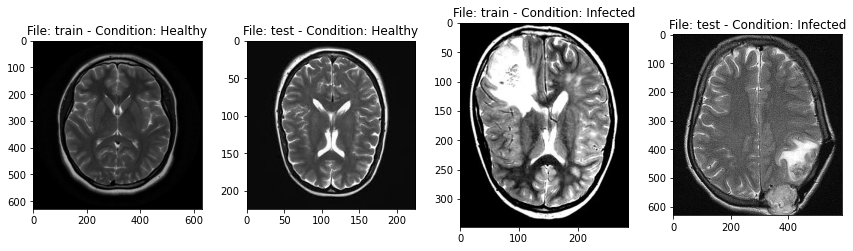

In [9]:
fig, ax = plt.subplots(1,4, figsize=(12,12))
ax = ax.ravel()
plt.tight_layout()
for i, _set in enumerate(['train', 'test']):
    set_path = input_path+_set
    ax[i].imshow(plt.imread(set_path+'/no/'+os.listdir(set_path+'/no')[0]),cmap='gray')
    ax[i].set_title('File: {} - Condition: Healthy'.format(_set))
    ax[i+2].imshow(plt.imread(set_path+'/yes/'+os.listdir(set_path+'/yes')[0]),cmap='gray')
    ax[i+2].set_title('File: {} - Condition: Infected'.format(_set))

In [10]:
train_datagen = ImageDataGenerator(
      rescale=1./255,
      rotation_range=40,
      width_shift_range=0.2,
      height_shift_range=0.2,
      horizontal_flip=True,
      fill_mode='nearest')

test_datagen = ImageDataGenerator(rescale=1./255)

train_generator = train_datagen.flow_from_directory(
        train_path,
        target_size=(150, 150),
        batch_size=20,
        class_mode='binary')
test_generator = test_datagen.flow_from_directory(
        test_path,
        target_size=(150, 150),
        batch_size=20,
        class_mode='binary')
validation_generator = test_datagen.flow_from_directory(
        val_path,
        target_size=(150, 150),
        batch_size=20,
        class_mode='binary')

Found 2349 images belonging to 2 classes.
Found 511 images belonging to 2 classes.
Found 381 images belonging to 2 classes.


In [11]:
def build_model(backbone, lr=1e-4):
    model = Sequential()
    model.add(backbone)
    model.add(layers.GlobalAveragePooling2D())
    model.add(Dropout(0.5))
    model.add(Dense(1,activation="sigmoid"))
    
    model.compile(
        loss='binary_crossentropy',
        optimizer=Adam(lr=lr),
        metrics=['acc']
    )
    return model

vgg16 = VGG16(
    weights='imagenet',
    include_top=False,
    input_shape=(150,150,3)
)

model = build_model(vgg16 ,lr = 1e-4)
model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
vgg16 (Functional)           (None, 4, 4, 512)         14714688  
_________________________________________________________________
global_average_pooling2d_1 ( (None, 512)               0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 512)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 513       
Total params: 14,715,201
Trainable params: 14,715,201
Non-trainable params: 0
_________________________________________________________________


In [12]:
history = model.fit(
    train_generator,
    steps_per_epoch=train_generator.samples//batch_size,
    epochs=25,
    validation_data=validation_generator,
    validation_steps=validation_generator.samples//batch_size
)

Epoch 1/25
117/117 [==============================] - 527s 5s/step - loss: 0.5969 - acc: 0.6887 - val_loss: 0.5652 - val_acc: 0.7184
Epoch 2/25
117/117 [==============================] - 526s 4s/step - loss: 0.2978 - acc: 0.8725 - val_loss: 0.2356 - val_acc: 0.9289
Epoch 3/25
117/117 [==============================] - 526s 4s/step - loss: 0.1579 - acc: 0.9450 - val_loss: 0.2136 - val_acc: 0.9316
Epoch 4/25
117/117 [==============================] - 530s 5s/step - loss: 0.1284 - acc: 0.9571 - val_loss: 0.1528 - val_acc: 0.9500
Epoch 5/25
117/117 [==============================] - 524s 4s/step - loss: 0.0612 - acc: 0.9828 - val_loss: 0.1400 - val_acc: 0.9711
Epoch 6/25
117/117 [==============================] - 525s 4s/step - loss: 0.0753 - acc: 0.9772 - val_loss: 0.2242 - val_acc: 0.9342
Epoch 7/25
117/117 [==============================] - 523s 4s/step - loss: 0.0586 - acc: 0.9802 - val_loss: 0.0820 - val_acc: 0.9711
Epoch 8/25
117/117 [==============================] - 523s 4s/step - 

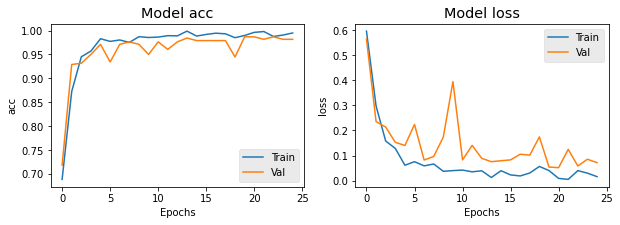

In [13]:
fig, ax = plt.subplots(1, 2, figsize=(10, 3))
ax = ax.ravel()

for i, met in enumerate(['acc', 'loss']):
    plt.style.use("ggplot")
    ax[i].plot(history.history[met])
    ax[i].plot(history.history['val_' + met])
    ax[i].set_title('Model {}'.format(met))
    ax[i].set_xlabel('Epochs')
    ax[i].set_ylabel(met)
    ax[i].legend(['Train', 'Val'])

In [14]:
from keras.preprocessing import image

def predict_image(model, img_path, img_dims = 150):
    img = image.load_img(img_path, target_size = (img_dims, img_dims))
    plt.imshow(img)
    plt.show()
    img = image.img_to_array(img)
    x = np.expand_dims(img, axis=0) * 1./255
    score = model.predict(x)
    print('Predictions: ', score, 'NORMAL' if score < 0.5 else 'TUMORLU')

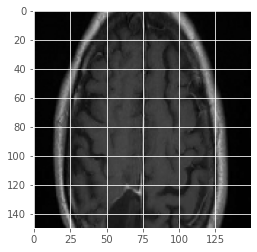

Predictions:  [[0.00897273]] NORMAL


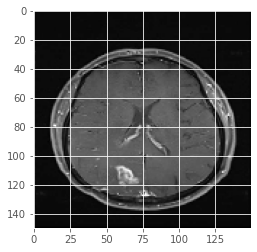

Predictions:  [[0.76072454]] TUMORLU


In [15]:
predict_image(model,(input_path +'predict/tumorsüz.jpg'))
predict_image(model,(input_path +'predict/tumörlü.jpg'))